In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
df["Text"].duplicated().sum()

np.int64(174875)

In [6]:
df = df.drop_duplicates(subset="Text")
df.shape

(393579, 10)

In [7]:
df["Text"].duplicated().sum()

np.int64(0)

In [8]:
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,16
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,3
Text,0


In [9]:
df["Text"].str.strip().eq("").sum()

np.int64(0)

In [10]:
df = df[["Text", "Score"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393579 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    393579 non-null  object
 1   Score   393579 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ MB


In [11]:
df["Score"].value_counts().sort_index()

,count
Score,
1,36275
2,20792
3,29754
4,56042
5,250716


<Axes: xlabel='Score'>

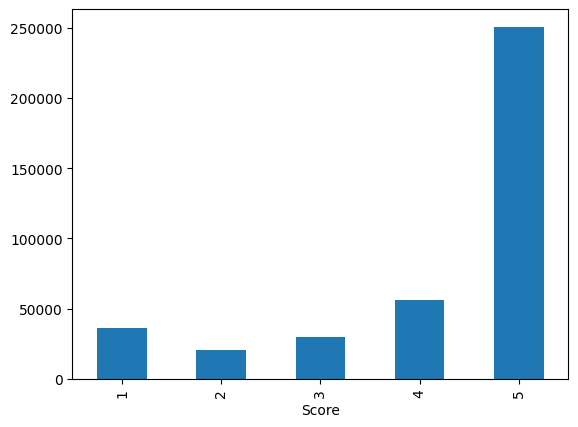

In [12]:
df["Score"].value_counts().sort_index().plot(kind="bar")

In [13]:
(df["Score"].value_counts(normalize=True)
   .sort_index()
   .mul(100)
   .round(2))

,proportion
Score,
1,9.22
2,5.28
3,7.56
4,14.24
5,63.70


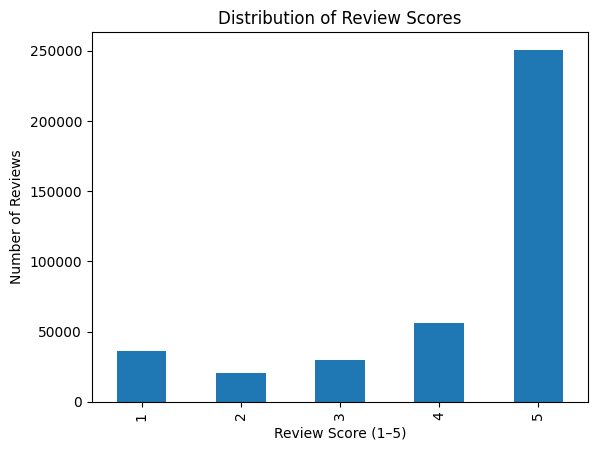

In [14]:
df["Score"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Review Score (1–5)")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Scores")
plt.show()

In [15]:
def map_sentiment(score):
    if score in [1, 2]:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

df["sentiment"] = df["Score"].apply(map_sentiment)

In [16]:
df["sentiment"].value_counts()

,count
sentiment,
Positive,306758
Negative,57067
Neutral,29754


In [17]:
(df["sentiment"].value_counts(normalize=True)
   .mul(100)
   .round(2))

,proportion
sentiment,
Positive,77.94
Negative,14.50
Neutral,7.56


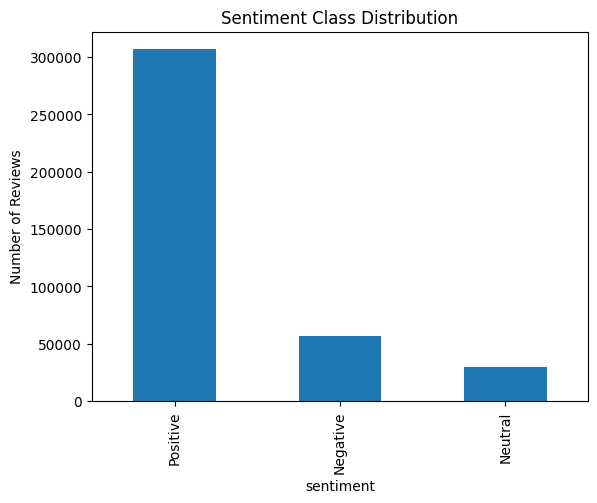

In [18]:
df["sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Class Distribution")
plt.ylabel("Number of Reviews")
plt.show()

In [19]:
df.sample(5, random_state=42)[["Text", "sentiment"]]

,Text,sentiment
508413,I have tried just about every gluten free past...,Positive
351680,I routinely purchase my dog treats through Ama...,Neutral
206063,I bought this product and love it. I have deci...,Positive
129501,I've been bouncing around from one brand of gr...,Positive
9569,I get these for $4.34 at my local health food ...,Positive


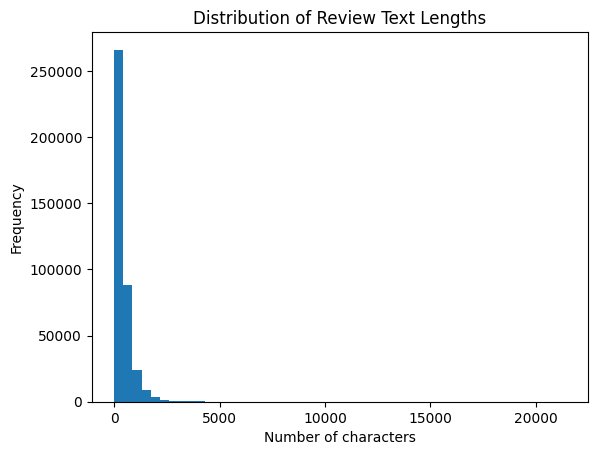

In [20]:
df["text_length"] = df["Text"].str.len()

df["text_length"].plot(kind="hist", bins=50)
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.title("Distribution of Review Text Lengths")
plt.show()

In [21]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)  # keep letters only
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [22]:
df["clean_text"] = df["Text"].apply(clean_text)

In [23]:
df.sample(5, random_state=42)[["Text", "clean_text"]]

,Text,clean_text
508413,I have tried just about every gluten free past...,i have tried just about every gluten free past...
351680,I routinely purchase my dog treats through Ama...,i routinely purchase my dog treats through ama...
206063,I bought this product and love it. I have deci...,i bought this product and love it i have decid...
129501,I've been bouncing around from one brand of gr...,i ve been bouncing around from one brand of gr...
9569,I get these for $4.34 at my local health food ...,i get these for at my local health food store ...


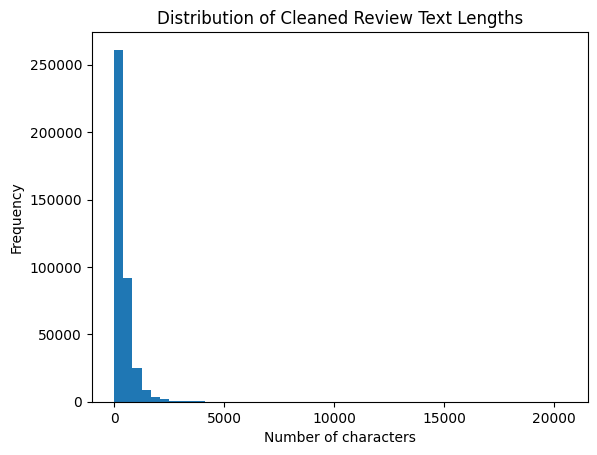

In [24]:
df["clean_length"] = df["clean_text"].str.len()

df["clean_length"].plot(kind="hist", bins=50)
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.title("Distribution of Cleaned Review Text Lengths")
plt.show()

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [26]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [27]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

len(stop_words)

198

In [28]:
def clean_text_advanced(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

In [29]:
df["clean_text_adv"] = df["Text"].apply(clean_text_advanced)

In [30]:
df.sample(5, random_state=42)[
    ["Text", "clean_text", "clean_text_adv"]
]

,Text,clean_text,clean_text_adv
508413,I have tried just about every gluten free past...,i have tried just about every gluten free past...,tried every gluten free pasta available hand b...
351680,I routinely purchase my dog treats through Ama...,i routinely purchase my dog treats through ama...,routinely purchase dog treat amazon convenienc...
206063,I bought this product and love it. I have deci...,i bought this product and love it i have decid...,bought product love decided buy much flour fut...
129501,I've been bouncing around from one brand of gr...,i ve been bouncing around from one brand of gr...,bouncing around one brand green tea another ti...
9569,I get these for $4.34 at my local health food ...,i get these for at my local health food store ...,get local health food store price suck one bes...


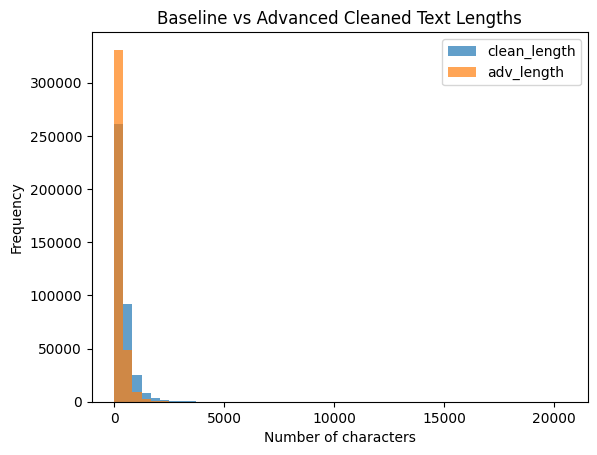

In [31]:
df["adv_length"] = df["clean_text_adv"].str.len()

df[["clean_length", "adv_length"]].plot(kind="hist", bins=50, alpha=0.7)
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.title("Baseline vs Advanced Cleaned Text Lengths")
plt.show()

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_base = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_base = tfidf_base.fit_transform(df["clean_text"])
X_base.shape

(393579, 482343)

In [33]:
tfidf_adv = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_adv = tfidf_adv.fit_transform(df["clean_text_adv"])
X_adv.shape

(393579, 459285)

In [34]:
print("Baseline vocabulary size:", len(tfidf_base.vocabulary_))
print("Advanced vocabulary size:", len(tfidf_adv.vocabulary_))

Baseline vocabulary size: 482343
Advanced vocabulary size: 459285


In [35]:
X_base_text = df["clean_text"]
X_adv_text  = df["clean_text_adv"]
y = df["sentiment"]

In [36]:
from sklearn.model_selection import train_test_split

Xb_train, Xb_test, y_train, y_test = train_test_split(
    X_base_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Xa_train, Xa_test, _, _ = train_test_split(
    X_adv_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [37]:
Xb_train_vec = tfidf_base.fit_transform(Xb_train)
Xb_test_vec  = tfidf_base.transform(Xb_test)

Xb_train_vec.shape, Xb_test_vec.shape

((314863, 410144), (78716, 410144))

In [38]:
Xa_train_vec = tfidf_adv.fit_transform(Xa_train)
Xa_test_vec  = tfidf_adv.transform(Xa_test)

Xa_train_vec.shape, Xa_test_vec.shape

((314863, 378890), (78716, 378890))

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

nb_base = MultinomialNB()
nb_base.fit(Xb_train_vec, y_train)

y_pred_nb_base = nb_base.predict(Xb_test_vec)

print("Naive Bayes – Baseline preprocessing")
print(classification_report(y_test, y_pred_nb_base, digits=4))

Naive Bayes – Baseline preprocessing
              precision    recall  f1-score   support

    Negative     0.9061    0.1716    0.2886     11413
     Neutral     0.0000    0.0000    0.0000      5951
    Positive     0.8004    0.9987    0.8887     61352

    accuracy                         0.8033     78716
   macro avg     0.5688    0.3901    0.3924     78716
weighted avg     0.7552    0.8033    0.7345     78716



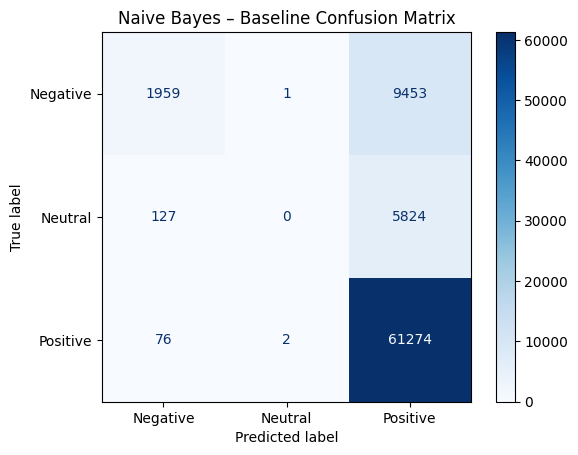

In [40]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_nb_base,
    cmap="Blues",
    values_format="d"
)
plt.title("Naive Bayes – Baseline Confusion Matrix")
plt.show()

In [41]:
nb_adv = MultinomialNB()
nb_adv.fit(Xa_train_vec, y_train)

y_pred_nb_adv = nb_adv.predict(Xa_test_vec)

print("Naive Bayes – Advanced preprocessing")
print(classification_report(y_test, y_pred_nb_adv, digits=4))

Naive Bayes – Advanced preprocessing
              precision    recall  f1-score   support

    Negative     0.9201    0.1514    0.2600     11413
     Neutral     0.5000    0.0002    0.0003      5951
    Positive     0.7979    0.9992    0.8873     61352

    accuracy                         0.8008     78716
   macro avg     0.7393    0.3836    0.3825     78716
weighted avg     0.7931    0.8008    0.7293     78716



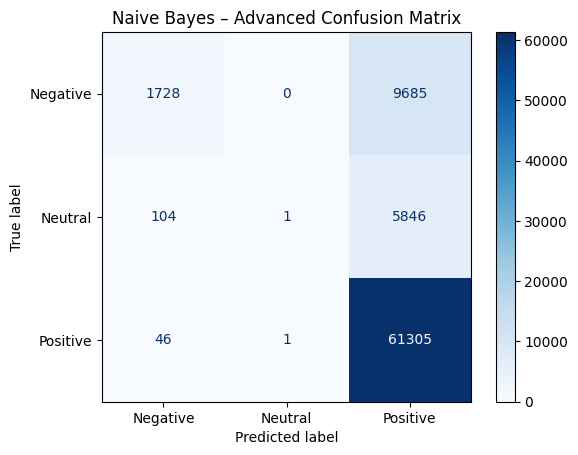

In [42]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_nb_adv,
    cmap="Blues",
    values_format="d"
)
plt.title("Naive Bayes – Advanced Confusion Matrix")
plt.show()

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

lr_base = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight="balanced"
)

lr_base.fit(Xb_train_vec, y_train)

y_pred_lr_base = lr_base.predict(Xb_test_vec)

print("Logistic Regression – Baseline preprocessing")
print(classification_report(y_test, y_pred_lr_base, digits=4))

Logistic Regression – Baseline preprocessing
              precision    recall  f1-score   support

    Negative     0.7054    0.7845    0.7429     11413
     Neutral     0.3421    0.5613    0.4251      5951
    Positive     0.9683    0.8879    0.9264     61352

    accuracy                         0.8483     78716
   macro avg     0.6719    0.7446    0.6981     78716
weighted avg     0.8829    0.8483    0.8619     78716



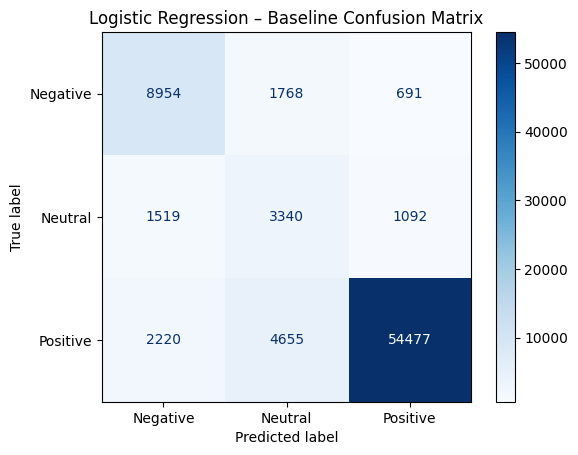

In [44]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lr_base,
    cmap="Blues",
    values_format="d"
)
plt.title("Logistic Regression – Baseline Confusion Matrix")
plt.show()

In [45]:
lr_adv = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    class_weight="balanced"
)

lr_adv.fit(Xa_train_vec, y_train)

y_pred_lr_adv = lr_adv.predict(Xa_test_vec)

print("Logistic Regression – Advanced preprocessing")
print(classification_report(y_test, y_pred_lr_adv, digits=4))

Logistic Regression – Advanced preprocessing
              precision    recall  f1-score   support

    Negative     0.6562    0.7599    0.7042     11413
     Neutral     0.3036    0.5019    0.3784      5951
    Positive     0.9582    0.8693    0.9116     61352

    accuracy                         0.8257     78716
   macro avg     0.6393    0.7104    0.6647     78716
weighted avg     0.8649    0.8257    0.8412     78716



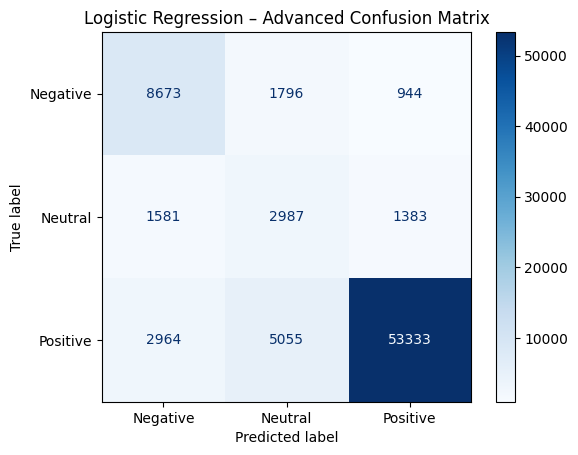

In [46]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lr_adv,
    cmap="Blues",
    values_format="d"
)
plt.title("Logistic Regression – Advanced Confusion Matrix")
plt.show()

In [47]:
def predict_sentiment(text):
    # Clean input text (baseline preprocessing)
    cleaned = clean_text(text)

    # Vectorize using trained TF-IDF
    vec = tfidf_base.transform([cleaned])

    # Predict sentiment
    prediction = lr_base.predict(vec)[0]

    # Prediction probabilities
    probs = lr_base.predict_proba(vec)[0]
    prob_dict = dict(zip(lr_base.classes_, probs))

    return prediction, prob_dict

In [48]:
test_texts = [
    "This product is amazing, I absolutely love it!",
    "It's okay, not great but not terrible either.",
    "Very disappointing quality, would not buy again."
]

for t in test_texts:
    pred, probs = predict_sentiment(t)
    print(f"\nText: {t}")
    print(f"Predicted sentiment: {pred}")
    print("Confidence:", {k: round(v, 3) for k, v in probs.items()})


Text: This product is amazing, I absolutely love it!
Predicted sentiment: Positive
Confidence: {'Negative': np.float64(0.0), 'Neutral': np.float64(0.002), 'Positive': np.float64(0.998)}

Text: It's okay, not great but not terrible either.
Predicted sentiment: Neutral
Confidence: {'Negative': np.float64(0.032), 'Neutral': np.float64(0.968), 'Positive': np.float64(0.0)}

Text: Very disappointing quality, would not buy again.
Predicted sentiment: Negative
Confidence: {'Negative': np.float64(0.994), 'Neutral': np.float64(0.006), 'Positive': np.float64(0.0)}


In [49]:
user_text = input("Enter a review text: ")

pred, probs = predict_sentiment(user_text)

print("\nPredicted Sentiment:", pred)
print("Prediction Confidence:")
for k, v in probs.items():
    print(f"  {k}: {v:.4f}")

Enter a review text: I received the item on time and it functions normally.

Predicted Sentiment: Positive
Prediction Confidence:
  Negative: 0.2837
  Neutral: 0.1445
  Positive: 0.5717


In [50]:
neutral_tests = [
    "The product works as described, but there is nothing particularly special about it.",
    "It does the job and meets basic expectations, but I wouldn’t go out of my way to recommend it.",
    "The quality is acceptable for the price, neither impressive nor disappointing.",
    "I received the item on time and it functions normally.",
    "It’s fine for everyday use, but there are better alternatives available."
]

for t in neutral_tests:
    pred, probs = predict_sentiment(t)
    print(f"\nText: {t}")
    print(f"Predicted sentiment: {pred}")
    print("Confidence:", {k: round(v, 3) for k, v in probs.items()})


Text: The product works as described, but there is nothing particularly special about it.
Predicted sentiment: Neutral
Confidence: {'Negative': np.float64(0.037), 'Neutral': np.float64(0.907), 'Positive': np.float64(0.056)}

Text: It does the job and meets basic expectations, but I wouldn’t go out of my way to recommend it.
Predicted sentiment: Neutral
Confidence: {'Negative': np.float64(0.018), 'Neutral': np.float64(0.941), 'Positive': np.float64(0.041)}

Text: The quality is acceptable for the price, neither impressive nor disappointing.
Predicted sentiment: Negative
Confidence: {'Negative': np.float64(0.795), 'Neutral': np.float64(0.201), 'Positive': np.float64(0.004)}

Text: I received the item on time and it functions normally.
Predicted sentiment: Positive
Confidence: {'Negative': np.float64(0.284), 'Neutral': np.float64(0.145), 'Positive': np.float64(0.572)}

Text: It’s fine for everyday use, but there are better alternatives available.
Predicted sentiment: Neutral
Confidence: 

In [51]:
 # Get probability predictions from baseline Logistic Regression
y_prob = lr_base.predict_proba(Xb_test_vec)

# Check class order
lr_base.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [52]:
from sklearn.preprocessing import label_binarize

# Convert y_test to binary (Positive = 1, others = 0)
y_test_bin = label_binarize(y_test, classes=lr_base.classes_)

# Index of Positive class
positive_index = list(lr_base.classes_).index("Positive")

y_test_positive = y_test_bin[:, positive_index]
y_prob_positive = y_prob[:, positive_index]

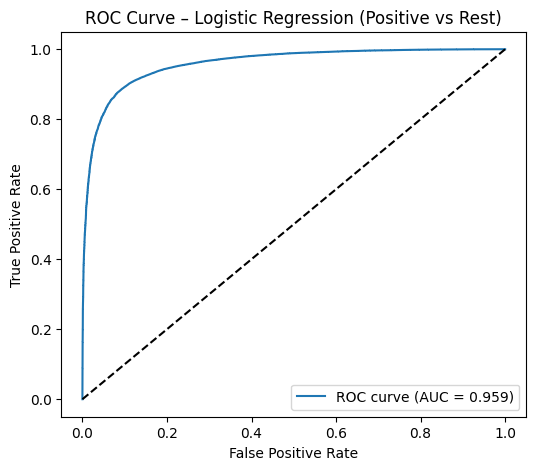

In [53]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_positive, y_prob_positive)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (Positive vs Rest)")
plt.legend(loc="lower right")
plt.show()

In [54]:
!pip install wordcloud

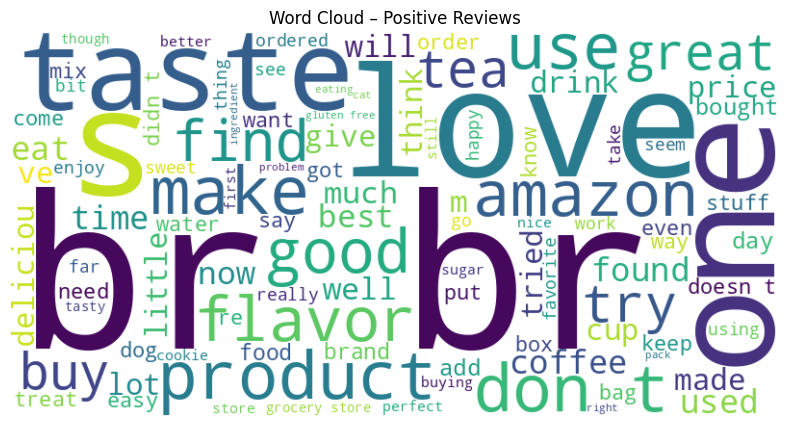

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_text = " ".join(df[df["sentiment"] == "Positive"]["clean_text"])

wordcloud_pos = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos.to_array(), interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Positive Reviews")
plt.show()

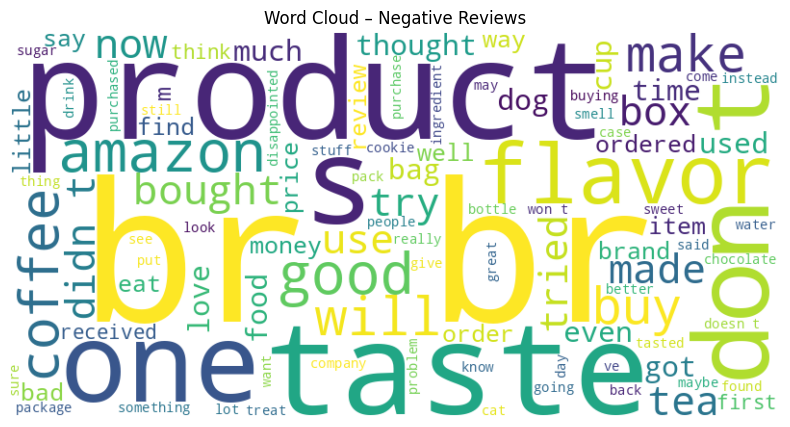

In [56]:
negative_text = " ".join(
    df[df["sentiment"] == "Negative"]["clean_text"]
)

wordcloud_neg = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg.to_array(), interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Negative Reviews")
plt.show()

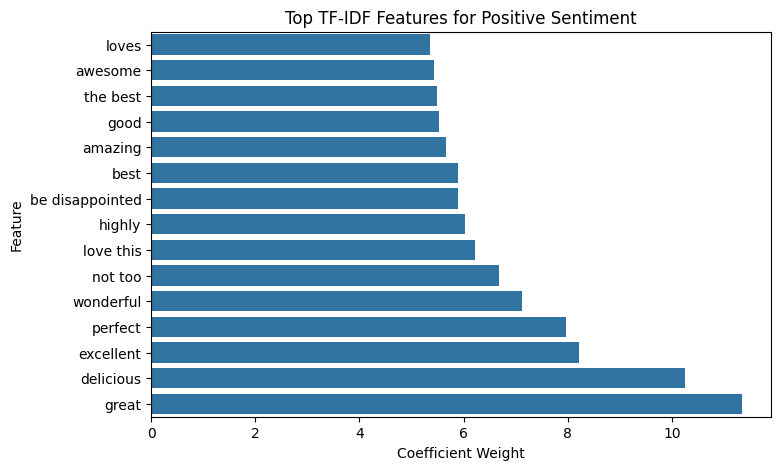

In [57]:
import numpy as np
import seaborn as sns

feature_names = tfidf_base.get_feature_names_out()
coef = lr_base.coef_

# Get index of Positive class
positive_index = list(lr_base.classes_).index("Positive")

# Get top positive coefficients
top_n = 15
top_pos_idx = np.argsort(coef[positive_index])[-top_n:]

top_pos_features = feature_names[top_pos_idx]
top_pos_values = coef[positive_index][top_pos_idx]

plt.figure(figsize=(8, 5))
sns.barplot(x=top_pos_values, y=top_pos_features)
plt.title("Top TF-IDF Features for Positive Sentiment")
plt.xlabel("Coefficient Weight")
plt.ylabel("Feature")
plt.show()

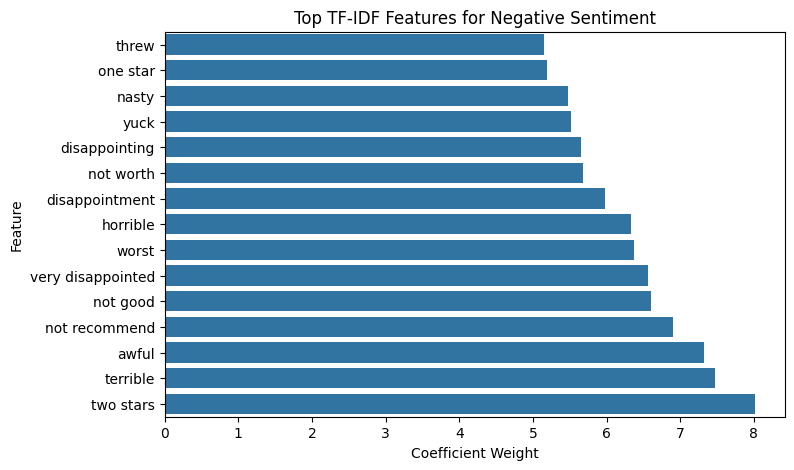

In [58]:
negative_index = list(lr_base.classes_).index("Negative")

top_neg_idx = np.argsort(coef[negative_index])[-top_n:]

top_neg_features = feature_names[top_neg_idx]
top_neg_values = coef[negative_index][top_neg_idx]

plt.figure(figsize=(8, 5))
sns.barplot(x=top_neg_values, y=top_neg_features)
plt.title("Top TF-IDF Features for Negative Sentiment")
plt.xlabel("Coefficient Weight")
plt.ylabel("Feature")
plt.show()

In [59]:
!pip install -q transformers datasets accelerate

In [60]:
import torch
import numpy as np
import pandas as pd

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [62]:
import torch
torch.cuda.is_available()

True

In [63]:
df[["Text", "Score"]].head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [64]:
if "sentiment" not in df.columns:
    def map_sentiment(score):
        if score in [1, 2]:
            return "Negative"
        elif score == 3:
            return "Neutral"
        else:
            return "Positive"

    df["sentiment"] = df["Score"].apply(map_sentiment)

df["sentiment"].value_counts()

,count
sentiment,
Positive,306758
Negative,57067
Neutral,29754


In [65]:
SAMPLES_PER_CLASS = 10000

df_sub = (
    df[["Text", "sentiment"]]
    .dropna()
    .groupby("sentiment", group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), SAMPLES_PER_CLASS), random_state=42))
    .reset_index(drop=True)
)

df_sub["sentiment"].value_counts()

/tmp/ipython-input-803712765.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), SAMPLES_PER_CLASS), random_state=42))


,count
sentiment,
Negative,10000
Neutral,10000
Positive,10000


In [66]:
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}
id2label = {v: k for k, v in label2id.items()}

df_sub["label"] = df_sub["sentiment"].map(label2id)

df_sub[["Text", "sentiment", "label"]].sample(5, random_state=42)

,Text,sentiment,label
2308,Received this item today and tried a cup immed...,Negative,0
22404,"I fell in love with this candy in Virginia, wh...",Positive,2
23397,The quality of the pistachios were mostly good...,Positive,2
25058,"I left the feedback couple days ago. Today, I ...",Positive,2
2664,I have bought several flavors of these fruit l...,Negative,0


In [67]:
df_sub["sentiment"].value_counts()

,count
sentiment,
Negative,10000
Neutral,10000
Positive,10000


In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    df_sub["Text"],
    df_sub["label"],
    test_size=0.2,
    random_state=42,
    stratify=df_sub["label"]
)

len(X_train), len(X_test)

(24000, 6000)

In [69]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [70]:
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

In [71]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [72]:
train_dataset = ReviewDataset(train_encodings, y_train)
test_dataset = ReviewDataset(test_encodings, y_test)

len(train_dataset), len(test_dataset)

(24000, 6000)

In [73]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [74]:
!pip install -U transformers accelerate

In [76]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none"
)

In [78]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "weighted_f1": f1_score(labels, preds, average="weighted"),
    }

In [79]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-2388959174.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [80]:
trainer.train()

Step,Training Loss
100,0.939700
200,0.726000
300,0.697700
400,0.687400
500,0.679400
600,0.654800
700,0.634100
800,0.643400
900,0.637300
1000,0.663100


TrainOutput(global_step=3000, training_loss=0.5818959312438965, metrics={'train_runtime': 685.6364, 'train_samples_per_second': 70.008, 'train_steps_per_second': 4.375, 'total_flos': 1589637132288000.0, 'train_loss': 0.5818959312438965, 'epoch': 2.0})

In [81]:
eval_results = trainer.evaluate()
eval_results

{'eval_loss': 0.610131025314331,
 'eval_accuracy': 0.7443333333333333,
 'eval_macro_f1': 0.7457722742633948,
 'eval_weighted_f1': 0.7457722742633949,
 'eval_runtime': 23.3816,
 'eval_samples_per_second': 256.612,
 'eval_steps_per_second': 16.038,
 'epoch': 2.0}

In [82]:
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

In [83]:
from sklearn.metrics import classification_report

print("DistilBERT Classification Report")
print(classification_report(
    y_true,
    y_pred,
    target_names=["Negative", "Neutral", "Positive"],
    digits=4
))

DistilBERT Classification Report
              precision    recall  f1-score   support

    Negative     0.7540    0.7370    0.7454      2000
     Neutral     0.6387    0.6770    0.6573      2000
    Positive     0.8509    0.8190    0.8346      2000

    accuracy                         0.7443      6000
   macro avg     0.7479    0.7443    0.7458      6000
weighted avg     0.7479    0.7443    0.7458      6000



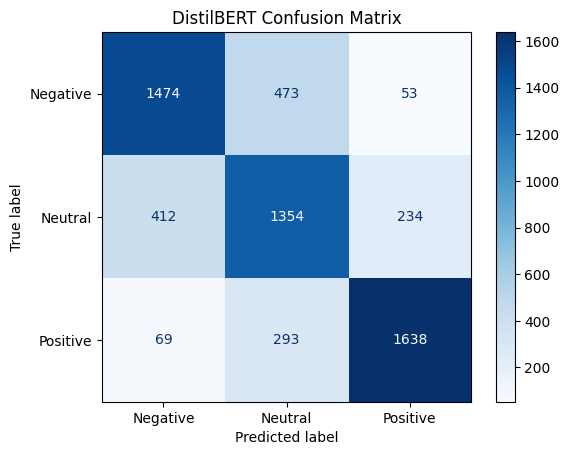

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=["Negative", "Neutral", "Positive"],
    cmap="Blues",
    values_format="d"
)

plt.title("DistilBERT Confusion Matrix")
plt.show()

In [85]:
import torch

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

def predict_sentiment(text):
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    return label_map[pred_class], probs.squeeze().cpu().numpy()

In [86]:
sentences = [
    "The product works as expected and does the job.",
    "I am extremely disappointed with the quality.",
    "It is okay, nothing special but not bad either.",
    "Absolutely love it, will buy again!",
    "The item arrived late and the packaging was damaged."
]

for s in sentences:
    label, probs = predict_sentiment(s)
    print(f"Text: {s}")
    print(f"Predicted sentiment: {label}")
    print("-" * 60)

Text: The product works as expected and does the job.
Predicted sentiment: Positive
------------------------------------------------------------
Text: I am extremely disappointed with the quality.
Predicted sentiment: Negative
------------------------------------------------------------
Text: It is okay, nothing special but not bad either.
Predicted sentiment: Neutral
------------------------------------------------------------
Text: Absolutely love it, will buy again!
Predicted sentiment: Positive
------------------------------------------------------------
Text: The item arrived late and the packaging was damaged.
Predicted sentiment: Negative
------------------------------------------------------------


In [87]:
label, probs = predict_sentiment("The product works as expected and does the job.")
print("Negative:", round(probs[0], 3))
print("Neutral :", round(probs[1], 3))
print("Positive:", round(probs[2], 3))

Negative: 0.012
Neutral : 0.135
Positive: 0.853
